In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from natsort import natsorted
import numpy as np
import matplotlib.animation as animation
import xarray as xr
import h5py
import imageio
import matplotlib
import gc
import sys
import io
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from scipy.optimize import curve_fit
import scipy.integrate

import scipy.ndimage
import re
# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(rf'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM

tidy3dAPI = os.environ["API_TIDY3D_KEY"]


In [2]:
field_ref = AM.read_hdf5_as_dict("./data/20251023_Balistic_Transmission/20251006_Ref_air_complete_field.h5")
field = AM.read_hdf5_as_dict("./data/20251023_Balistic_Transmission/20251006_far_field_eps_8p570256250000002_ff_21p72_air_complete_field.h5")

In [3]:
#Open experimental data 
with open(r"H:\phd stuff\tidy3d\Notebooks\LSU Project\20250410 Sphere Discretization LSU\data\20251023_Balistic_Transmission\h09p4_sample3_spot1.txt", 'rb') as file:
        content = file.read()

        
# Decode the binary content to a string
decoded_content = content.decode('utf-8')

# Split the content into lines
lines = decoded_content.split('\r\n')
# Initialize an empty list to store the parsed values
experiment_data= []

# Loop through each line and split by the comma
for line in lines:
    if line:  # Skip any empty lines
        value1 = line.split(',')[6]
        experiment_data.append(float(value1))  # Convert values to float

In [4]:
#Open experimental data 
with open(r"H:\phd stuff\tidy3d\Notebooks\LSU Project\20250410 Sphere Discretization LSU\data\20251023_Balistic_Transmission\wavelenght_2_8_mu.txt", 'rb') as file:
        content = file.read()

        
# Decode the binary content to a string
decoded_content = content.decode('utf-8')

# Split the content into lines
lines = decoded_content.split('\r\n')
# Initialize an empty list to store the parsed values
lambdas_experiment= []

# Loop through each line and split by the comma
for line in lines:
    if line:  # Skip any empty lines
        value1 = line.split(',')[0]
        lambdas_experiment.append(float(value1))  # Convert values to float

In [5]:
field.keys()

dict_keys(['Ephi', 'Er', 'Etheta', 'freqs', 'phi_proj', 'r_proj', 'theta_proj'])

In [6]:
def solid_angle_weights(theta):
    # theta: 1D array of polar angles (radians), length nθ
    # assume phi grid uniform; we compute Δθ and Δφ from vectors
    ntheta = theta.size
    # if theta input is cell centers, use diffs; else approximate
    dtheta = np.empty(ntheta)
    dtheta[1:-1] = 0.5*(theta[2:]-theta[1:-1]) + 0.5*(theta[1:-1]-theta[:-2])
    dtheta[0] = theta[1]-theta[0]
    dtheta[-1] = theta[-1]-theta[-2]
    return np.sin(theta) * dtheta  # returns length ntheta, ΔΩ = sinθ Δθ Δφ (φ part multiplies later)

def compute_ballistic(
    E_theta_ref, E_phi_ref,   # shape (n_freq, n_theta, n_phi) complex (use None if missing)
    E_theta_scat, E_phi_scat, # same shapes for scatterer
    theta, phi                 # 1D arrays in radians
):
    # phi spacing (assume uniform)
    dphi=np.diff(phi)[1]
    w_theta = solid_angle_weights(theta)   # shape (n_theta,)
    # make 2D weight grid ΔΩ_ij = sinθ * Δθ * Δφ
    W = np.outer(w_theta, np.ones_like(phi)) * dphi  # shape (n_theta, n_phi)
    nfreq = E_theta_ref.shape[-1] if E_theta_ref is not None else E_phi_ref.shape[-1]
    T_ballistic = np.zeros(nfreq, dtype=float)

    for k in range(nfreq):
        # vectorial inner product: sum over components E_theta*conj(E_theta_ref)+E_phi*conj(E_phi_ref)
        inner_num = np.sum((E_theta_scat[:,:,k]*np.conj(E_theta_ref[:,:,k]) + E_phi_scat[:,:,k]*np.conj(E_phi_ref[:,:,k])) * W)
        inner_den = np.sum((E_theta_ref[:,:,k]*np.conj(E_theta_ref[:,:,k]) + E_phi_ref[:,:,k]*np.conj(E_phi_ref[:,:,k])) * W)

        A = inner_num / inner_den
        T_ballistic[k] = np.abs(A)**2

    return T_ballistic  # array over frequencies


In [7]:
transmission_full = compute_ballistic(field_ref["Etheta"].squeeze(),field_ref["Ephi"].squeeze(),field["Etheta"].squeeze(),field["Ephi"].squeeze(),field["theta_proj"],field["phi_proj"])

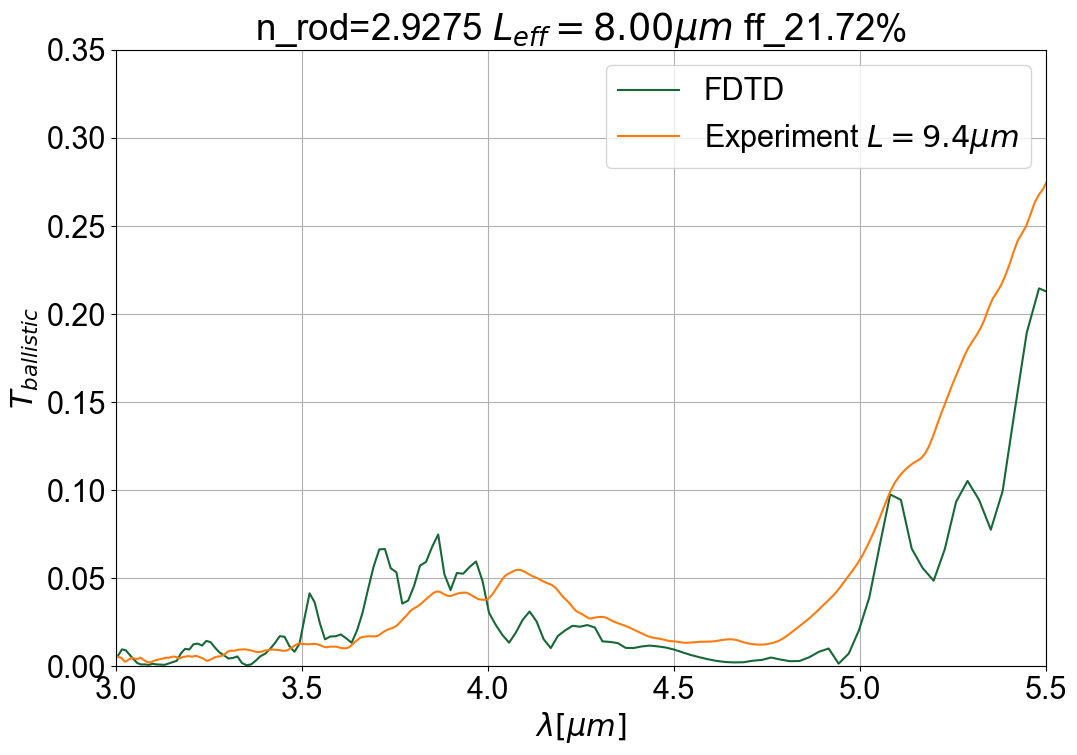

In [20]:
plt.rcParams.update({'font.size': 22})  
plt.rc('font', family='Arial')
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(td.C_0/field_ref["freqs"],transmission_full,label="FDTD")
plt.plot(lambdas_experiment,experiment_data,label=r"Experiment $L=9.4\mu m$")
plt.ylim(0,0.35)
plt.xlim(3,5.5)
plt.grid(visible=True,which="both")
plt.ylabel(rf"$T_{{ballistic}}$")
plt.xlabel(rf"$\lambda[\mu m]$")
plt.title(rf"n_rod=2.9275 $L_{{eff}}=8.00 \mu m$ ff_21.72%")
plt.legend()
plt.show()